In [1]:
import torch
print("PyTorch Version:", torch.__version__)

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


PyTorch Version: 2.5.1+cu121
Device: cuda


In [2]:
import pickle
import os
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from torchvision import models
from torch.amp import GradScaler, autocast
import random
import time
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
# Preprocessing for Dataset 1 (WM811K)
def preprocess_wm811k_data(path_to_dataset, target_size=(32, 32), num_classes=8, multi_label_ratio = 1.0):
    """
    Load and preprocess the WM811K dataset and generate synthetic multi-label data.

    Parameters:
        path_to_dataset (str): Path to the WM811K .pkl dataset.
        target_size (tuple): Desired image size.
        num_classes (int): Total number of classes.
        multi_label_ratio (float): Fraction of multi-label samples to generate.

    Returns:
        np.ndarray: Preprocessed wafer maps.
        np.ndarray: Multi-label one-hot encoded labels.
    """
    df = pd.read_pickle(path_to_dataset)
    df = df.drop(['waferIndex'], axis=1)
    #df['waferMapDim'] = df['waferMap'].apply(lambda x: (np.size(x, axis=0), np.size(x, axis=1)))
    df['failureNum'] = df['failureType']

    mapping_type = {
        'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
        'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': -1}
    df = df.replace({'failureNum': mapping_type})
    df  = df[(df['failureNum'] >= 0)].reset_index()

    # Filter out invalid data
    valid_indices = df["failureNum"].apply(lambda x: x is not None and isinstance(x, (int, np.integer)))
    df = df[valid_indices]

    wafer_maps = df['waferMap'].to_numpy()
    labels = df['failureNum'].to_numpy()

    processed_maps = []
    for wafer_map in wafer_maps:
        if wafer_map.size == 0:  # Skip invalid or empty maps
            continue
        wafer_map = np.array(wafer_map, dtype=np.float32)
        wafer_map = (wafer_map - np.min(wafer_map)) / (np.max(wafer_map) - np.min(wafer_map))
        scaling_factor = min(target_size[1] / wafer_map.shape[1], target_size[0] / wafer_map.shape[0])
        new_width = int(wafer_map.shape[1] * scaling_factor)
        new_height = int(wafer_map.shape[0] * scaling_factor)
        resized_map = cv2.resize(wafer_map, (new_width, new_height), interpolation=cv2.INTER_AREA)
        padded_map = np.full(target_size, 0, dtype=np.float32)
        x_offset = (target_size[1] - new_width) // 2
        y_offset = (target_size[0] - new_height) // 2
        padded_map[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_map
        processed_maps.append(padded_map)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    labels = labels.reshape(-1, 1)  # Reshape for one-hot encoding
    
    # Separate 'none' and encode others
    is_none = labels == -1
    one_hot_labels = encoder.fit_transform(labels[~is_none].reshape(-1,1))
    final_labels = np.zeros((len(labels), num_classes), dtype=np.float32)
    final_labels[~is_none.flatten()] = one_hot_labels


    # Generate synthetic multi-label samples directly without oversampling
    num_samples = len(processed_maps)
    print(num_samples)
    num_multi_class_samples = int(multi_label_ratio * num_samples)
    multi_class_maps = []
    multi_class_labels = []

    for _ in range(num_multi_class_samples):
         #Randomly select two or more samples to combine
        indices = np.random.choice(len(processed_maps), size=2, replace=False)
        
        # Combine maps with consistent dimensions
        combined_map = np.maximum(processed_maps[indices[0]], processed_maps[indices[1]])
        combined_label = np.logical_or(final_labels[indices[0]], final_labels[indices[1]]).astype(np.float32)

        # Ensure padding for consistency
        resized_combined_map = cv2.resize(combined_map, target_size, interpolation=cv2.INTER_AREA)
        multi_class_maps.append(resized_combined_map)
        multi_class_labels.append(combined_label)
        
    # Combine original and synthetic data
    all_maps = np.vstack([np.array(processed_maps), np.array(multi_class_maps)])
    all_labels = np.vstack([final_labels, np.array(multi_class_labels)])

    return np.expand_dims(all_maps, axis=1), all_labels

  

In [4]:
# Preprocessing for Dataset 2 (MixedWM38)
def preprocess_npz_dataset(path, target_size=(32, 32), num_classes= 8):
    """
    Preprocess the .npz dataset for mixed-type wafer maps.

    Parameters:
        path (str): Path to the .npz dataset.
        target_size (tuple): Desired image size.

    Returns:
        np.ndarray: Preprocessed wafer maps.
        np.ndarray: Multi-label one-hot encoded labels.
    """
    data = np.load(path)
    wafer_maps = data['arr_0']
    multi_labels = data['arr_1']

    # Exclude samples where all labels are zero (indicating 'none')
    valid_indices = np.any(multi_labels, axis=1)
    wafer_maps = wafer_maps[valid_indices]
    multi_labels = multi_labels[valid_indices]

    processed_maps = []
    for wafer_map in wafer_maps:
        wafer_map = np.array(wafer_map, dtype=np.float32)
        wafer_map = (wafer_map - np.min(wafer_map)) / (np.max(wafer_map) - np.min(wafer_map))
        resized_map = cv2.resize(wafer_map, target_size, interpolation=cv2.INTER_AREA)
        processed_maps.append(resized_map)

    # One-hot encode multi-labels, excluding 'none'
    multi_label_one_hot = np.zeros((len(multi_labels), num_classes), dtype=np.float32)
    for i, label in enumerate(multi_labels):
        for defect in label.nonzero()[0]:
            if defect < num_classes:  # Exclude "none" from encoding
                multi_label_one_hot[i, defect] = 1

    return np.expand_dims(np.array(processed_maps), axis=1), multi_label_one_hot

In [5]:

train_data, train_labels = preprocess_wm811k_data("data/WM811K.pkl",target_size=(32, 32), num_classes=8, multi_label_ratio=1.0)
test_data, test_labels = preprocess_npz_dataset("data/MLWM38K.npz", target_size=(32, 32), num_classes=8)

# # Save train data and labels
# np.savez_compressed("data/preprocessed_train_data.npz", data=train_data, labels=train_labels)

# # Save test data and labels
# np.savez_compressed("data/preprocessed_test_data.npz", data=test_data, labels=test_labels)

# print("Preprocessed data saved successfully!")



25519


In [6]:
print("Preprocessed data loaded successfully!")
# Load train data and labels
# train_data = np.load("data/preprocessed_train_data.npz")['data']
# train_labels = np.load("data/preprocessed_train_data.npz")['labels']
print(f"Train Data Shape: {train_data.shape}, Train Labels Shape: {train_labels.shape}")

# Load test data and labels
# test_data = np.load("data/preprocessed_test_data.npz")['data']
# test_labels = np.load("data/preprocessed_test_data.npz")['labels']
print(f"Test Data Shape: {test_data.shape}, Test Labels Shape: {test_labels.shape}")

Preprocessed data loaded successfully!
Train Data Shape: (51038, 1, 32, 32), Train Labels Shape: (51038, 8)
Test Data Shape: (37015, 1, 32, 32), Test Labels Shape: (37015, 8)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(data, labels, num_samples=5, dataset_name="Dataset"):
    """
    Visualizes random samples from the dataset with their labels.

    Parameters:
        data (np.ndarray): Wafer map data (preprocessed).
        labels (np.ndarray): Corresponding labels (one-hot encoded).
        num_samples (int): Number of samples to visualize.
        dataset_name (str): Name of the dataset for title purposes.
    """
    num_classes = labels.shape[1]
    indices = np.random.choice(len(data), size=num_samples, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices):
        wafer_map = data[idx].squeeze()  # Remove channel dimension
        label = labels[idx]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(wafer_map, cmap='gray')
        label_text = ', '.join([f"Class {j}" for j in range(num_classes) if label[j] == 1])
        plt.title(f"Sample {idx}\n{label_text if label_text else 'None'}")
        plt.axis('off')

    plt.suptitle(f"Random Samples from {dataset_name}")
    plt.tight_layout()
    plt.show()



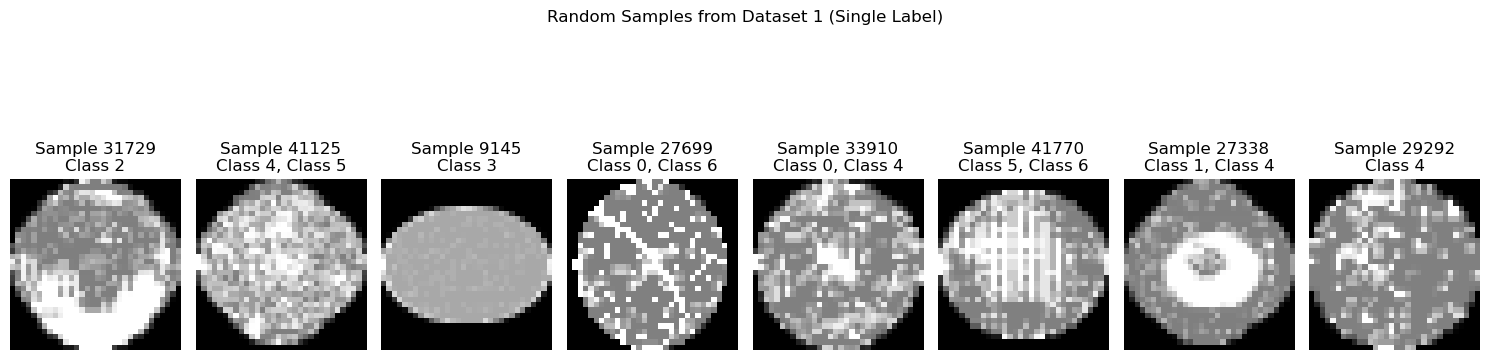

In [8]:
# Visualize Dataset 1
visualize_samples(train_data, train_labels, num_samples=8, dataset_name="Dataset 1 (Single Label)")



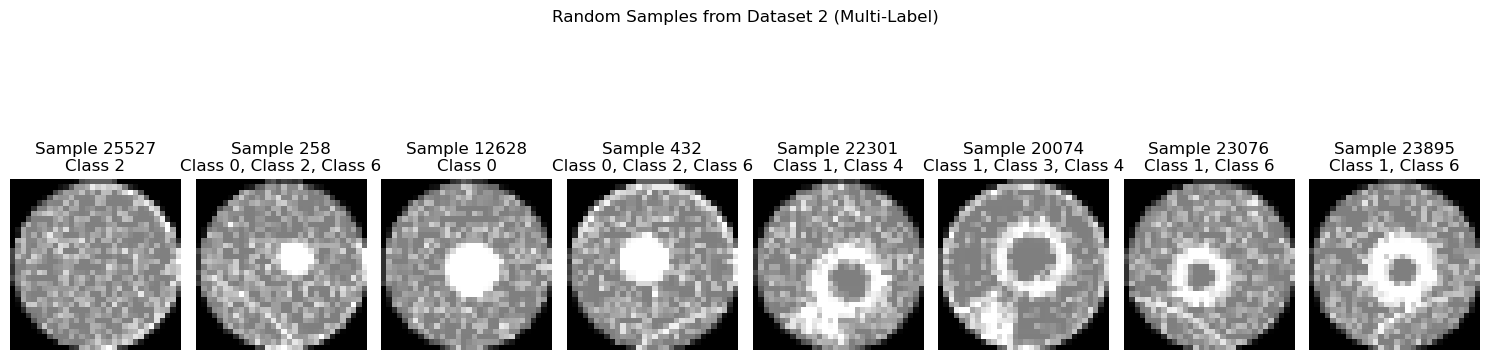

In [9]:
# Visualize Dataset 2
visualize_samples(test_data, test_labels, num_samples=8, dataset_name="Dataset 2 (Multi-Label)")


In [10]:
# Sum along the first axis (rows) to get the count of samples for each class
class_counts = train_labels.sum(axis=0)

# Normalize to get the proportion of each class
class_proportions = class_counts / train_labels.shape[0]

print("Class Counts:", class_counts)
print("Class Proportions:", class_proportions)

Class Counts: [12079.  1691. 14475. 25275. 10292.  2591.  3529.   423.]
Class Proportions: [0.2366668  0.03313218 0.28361222 0.49521926 0.20165367 0.0507661
 0.06914456 0.00828794]


In [11]:
# Sum along the first axis (rows) to count occurrences of each class across all samples
class_counts = test_labels.sum(axis=0)

# Normalize to get proportions
class_proportions = class_counts / test_labels.shape[0]

print("Class Counts:", class_counts)
print("Class Proportions:", class_proportions)


Class Counts: [13000. 12000. 13000. 12000. 18000.   149. 19000.   866.]
Class Proportions: [0.35120896 0.32419288 0.35120896 0.32419288 0.48628935 0.0040254
 0.5133054  0.02339592]


In [12]:
# Custom Dataset for PyTorch
class WaferDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [13]:
class VGG16Classifier(nn.Module):
    def __init__(self, init_weights=True, num_classes= 8, feature_dim=512):
        """
        VGG16-based Classifier for multi-label classification.

        Parameters:
            init_weights (bool): Whether to initialize weights.
            num_class (int): Number of output classes.
            feature_dim (int): Feature dimensionality from the feature extractor.
        """
        super(VGG16Classifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(feature_dim, 256),
            #nn.BatchNorm1d(256),
            #nn.ReLU(True),
            #nn.Dropout(0.8),
            #nn.Linear(256, 128),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.8),
            nn.Linear(256, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten features for linear layers
        x = self.classifier(x)
        return x #torch.sigmoid(x)  # Sigmoid for multi-label classification

    def _initialize_weights(self):
        """
        Initializes the weights of the classifier layers.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
        # for m in self.modules():
        #     if isinstance(m, nn.Linear):
        #         nn.init.kaiming_normal_(m.weight)
        #         if m.bias is not None:
        #             nn.init.constant_(m.bias, 0)


In [14]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        """
        Early stops the training if validation loss doesn't improve after a given patience.
        
        Parameters:
            patience (int): Number of epochs to wait before stopping.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): Whether to print messages when stopping.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [15]:
class CDADA:
    def __init__(self, train_data, train_labels,test_data,test_labels, num_classes = 8, max_epoch=50, batch_size=32, learning_rate=0.0001, subset_size=None):
        """
        Initializes the CDADA training and evaluation pipeline.

        Parameters:
            train_data (np.ndarray): Training data.
            train_labels (np.ndarray): Labels for the training data.
            test_data (np.ndarray): Testing data.
            test_labels (np.ndarray): Labels for the testing data.
            num_classes (int): Number of classes for multi-label classification.
            max_epoch (int): Maximum number of epochs.
            batch_size (int): Batch size for training and testing.
            learning_rate (float): Learning rate for optimizers.
        """
        # Create subset if subset_size is specified
        if subset_size is not None:
            indices = np.random.choice(len(train_data), subset_size, replace=False)
            train_data, train_labels = train_data[indices], train_labels[indices]
            self.train_loader = DataLoader(WaferDataset(train_data, train_labels), batch_size=batch_size, shuffle=True, drop_last=True)
        else:
            # Use full dataset
            self.train_loader = DataLoader(WaferDataset(train_data, train_labels), batch_size=batch_size, shuffle=True,drop_last=True)
        #self.train_loader = DataLoader(WaferDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(WaferDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)
        self.num_classes = num_classes
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate
    
        # Initialize VGG16 model
        #model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
        model = models.vgg16(pretrained=True)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Modify for grayscale input
        self.feature_extractor = model.features.to(device)
        self.classifier = VGG16Classifier(num_classes=num_classes).to(device)

        #optimizer and loss
        self.optimizer = optim.Adam(list(self.feature_extractor.parameters()) + list(self.classifier.parameters()), lr=learning_rate,weight_decay=1e-4) #weight_decay=1e-4
        #self.optimizer = optim.Adam(self.classifier.parameters(), lr=learning_rate)
        
        # Learning Rate Scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=2)

        # Compute class weights
        class_counts = train_labels.sum(axis=0)  # Sum occurrences for each class
        total_samples = len(train_labels)
        class_weights = total_samples / (num_classes * class_counts)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

        self.criterion =  nn.CrossEntropyLoss().to('cuda') #nn.BCEWithLogitsLoss(pos_weight=self.class_weights)
        
        # Track losses
        self.train_losses = []
        self.val_losses = []

    def reset_grad(self):
        self.opt_generator.zero_grad()
        self.opt_classifier.zero_grad()

    def train(self):
        """
        Trains the model with the weighted loss function.
        """
        self.feature_extractor.train()
        self.classifier.train()

        # Initialize early stopping
        #early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)



        for ep in range(self.max_epoch):
            time_start = time.time()
            running_loss = 0

            for images, labels in self.train_loader:
                images, labels = images.to(device), labels.to(device)

                self.optimizer.zero_grad()
                
                #forward pass
                features = self.feature_extractor(images)
                outputs = self.classifier(features)

                #loss and optimization
                loss = self.criterion(outputs, labels)
                loss.backward()

                # Apply gradient clipping
                # torch.nn.utils.clip_grad_norm_(self.feature_extractor.parameters(), max_norm=1.0)
                # torch.nn.utils.clip_grad_norm_(self.classifier.parameters(), max_norm=1.0)

                self.optimizer.step()

                running_loss += loss.item()


             # Log training loss
            avg_train_loss = running_loss / len(self.train_loader)
            self.train_losses.append(avg_train_loss)

            # Validation Loop
            val_loss = self._validate()
            self.val_losses.append(val_loss)

            # Scheduler step
            self.scheduler.step(val_loss)
            
            time_end = time.time()
            time_cost = time_end - time_start
            
            print(f"Epoch {ep + 1}/{self.max_epoch}, Train Loss: {avg_train_loss:.4f},Val Loss: {val_loss:.4f}, Time: {time_cost:.2f}s")

            # Check for early stopping
            # early_stopping(val_loss)
            # if early_stopping.early_stop:
            #     print("Early stopping triggered!")
            #     break


    def _validate(self):
        """
        Computes validation loss.
        """
        self.feature_extractor.eval()
        self.classifier.eval()
        val_loss = 0

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(device), labels.to(device)
                features = self.feature_extractor(images)
                outputs = self.classifier(features)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(self.test_loader)
        return avg_val_loss

    def test(self):
        """
        Tests the model and computes accuracy, precision, recall, and F1 score..
        """
        self.feature_extractor.eval()
        self.classifier.eval()

        all_labels = []
        all_outputs = []
        all_predictions = []  # To store predictions for accuracy

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(device), labels.to(device)

                features = self.feature_extractor(images)
                outputs = self.classifier(features)

                all_labels.append(labels.cpu())
                all_outputs.append(torch.sigmoid(outputs).cpu())
                
                # Apply threshold for predictions
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                all_predictions.append(predicted.cpu())
                    

        all_labels = torch.cat(all_labels)
        all_outputs = torch.cat(all_outputs)
        
        all_predictions = torch.cat(all_predictions)  # Apply threshold for multi-label classification

        #Metrics
        accuracy = (all_predictions == all_labels).all(dim=1).float().mean().item() * 100
        precision = precision_score(all_labels, all_outputs.round(), average='samples')
        recall = recall_score(all_labels, all_outputs.round(), average='samples')
        f1 = f1_score(all_labels, all_outputs.round(), average='samples')
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

        return all_outputs
    

    def plot_loss(self):
        """
        Visualizes training and validation loss over epochs.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Train Loss")
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.show()


In [16]:
cdada = CDADA(train_data, train_labels, test_data, test_labels, num_classes=8, max_epoch=50, subset_size = None)

c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
cdada.train()

Epoch 1/50, Train Loss: 1.7877,Val Loss: 4.7105, Time: 36.02s
Epoch 2/50, Train Loss: 1.2974,Val Loss: 4.7552, Time: 33.83s
Epoch 3/50, Train Loss: 1.1376,Val Loss: 4.6046, Time: 35.07s
Epoch 4/50, Train Loss: 1.0569,Val Loss: 5.3018, Time: 35.92s
Epoch 5/50, Train Loss: 1.0014,Val Loss: 5.1111, Time: 35.81s
Epoch 6/50, Train Loss: 0.9547,Val Loss: 5.5255, Time: 35.29s
Epoch 7/50, Train Loss: 0.8503,Val Loss: 5.4540, Time: 35.40s
Epoch 8/50, Train Loss: 0.8049,Val Loss: 5.5968, Time: 35.29s
Epoch 9/50, Train Loss: 0.7696,Val Loss: 5.5384, Time: 35.93s
Epoch 10/50, Train Loss: 0.6998,Val Loss: 5.9716, Time: 35.97s
Epoch 11/50, Train Loss: 0.6755,Val Loss: 6.9831, Time: 35.83s
Epoch 12/50, Train Loss: 0.6558,Val Loss: 6.5460, Time: 36.06s
Epoch 13/50, Train Loss: 0.6228,Val Loss: 7.3471, Time: 36.88s
Epoch 14/50, Train Loss: 0.6096,Val Loss: 7.3855, Time: 36.17s
Epoch 15/50, Train Loss: 0.6007,Val Loss: 7.8248, Time: 35.45s
Epoch 16/50, Train Loss: 0.5861,Val Loss: 8.1994, Time: 35.47s
E

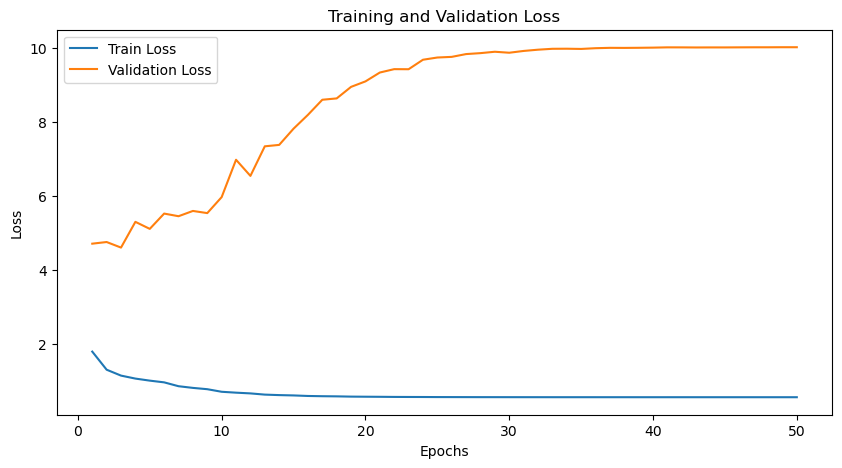

In [18]:
cdada.plot_loss()  # To visualize training and validation loss.

In [19]:
cdada.test()

Accuracy: 12.64%
Precision: 0.6326, Recall: 0.6869, F1-Score: 0.6226


tensor([[9.7436e-01, 7.8528e-05, 3.7054e-01,  ..., 2.8053e-02, 1.0448e-01,
         1.1623e-03],
        [9.9499e-01, 1.4496e-04, 4.4208e-01,  ..., 1.7549e-02, 7.1073e-01,
         4.4795e-07],
        [9.9809e-01, 5.2136e-06, 9.3671e-01,  ..., 2.9977e-04, 2.0686e-01,
         2.7481e-07],
        ...,
        [2.4806e-01, 3.6658e-04, 1.4600e-01,  ..., 1.5550e-07, 9.8001e-01,
         3.1487e-10],
        [2.1994e-02, 1.7096e-02, 4.9123e-01,  ..., 4.8092e-02, 9.9628e-01,
         3.3536e-09],
        [2.0485e-02, 6.4465e-01, 1.4561e-01,  ..., 4.6416e-01, 9.9653e-01,
         4.0760e-13]])

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

def visualize_dataset(data, labels, title="Dataset Visualization", classes=None, cmap='gray'):
    """
    Visualizes the class distribution and random samples from the dataset.

    Parameters:
        data (np.ndarray): Wafer map images.
        labels (np.ndarray): Corresponding labels (can be one-hot encoded).
        title (str): Title for the visualization.
        classes (list, optional): Class names corresponding to labels.
        cmap (str): Colormap for grayscale images.
    """
    # Convert one-hot labels to scalar indices if necessary
    if len(labels.shape) > 1:  # Check if labels are one-hot encoded
        labels = np.argmax(labels, axis=1)

    # Plot class distribution
    class_counts = Counter(labels)
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    if classes:
        plt.xticks(range(len(classes)), classes, rotation=45)
    else:
        plt.xticks(range(max(class_counts.keys()) + 1))
    plt.show()

    # Display random samples from the dataset
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    indices = np.random.choice(len(data), size=5, replace=False)
    for i, idx in enumerate(indices):
        axes[i].imshow(data[idx].squeeze(), cmap=cmap)
        axes[i].set_title(f"Class: {labels[idx]}")
        axes[i].axis('off')
    plt.suptitle(f"Random Samples: {title}")
    plt.show()


25519


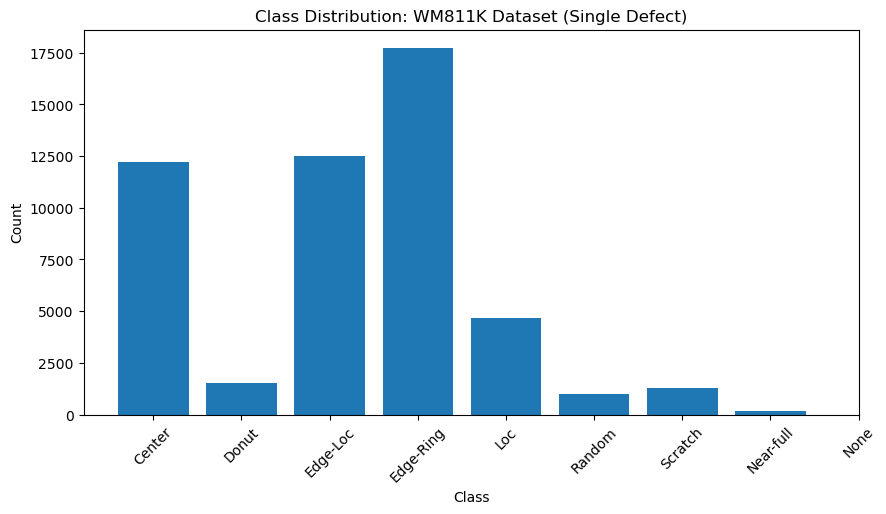

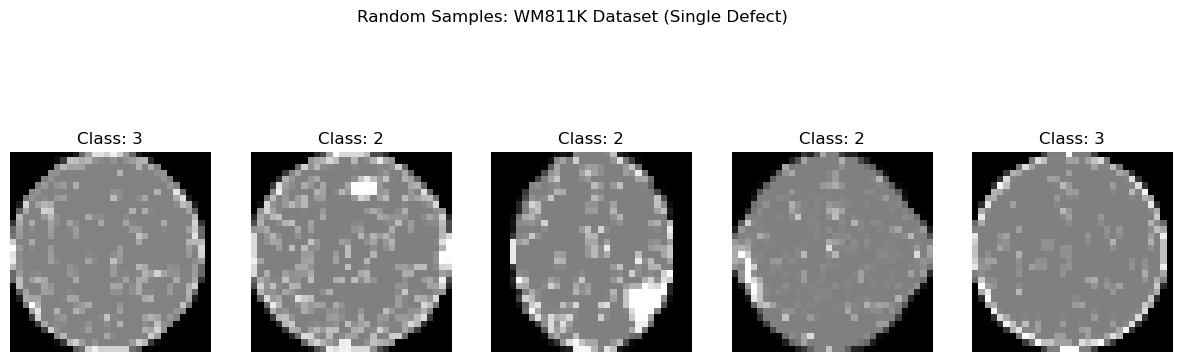

In [21]:
# Load Dataset1 (WM811K)
wm811k_data, wm811k_labels = preprocess_wm811k_data("data/WM811K.pkl")

# Class Names for WM811K
wm811k_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'None']

# Visualize WM811K Dataset
visualize_dataset(wm811k_data, wm811k_labels, title="WM811K Dataset (Single Defect)", classes=wm811k_classes)


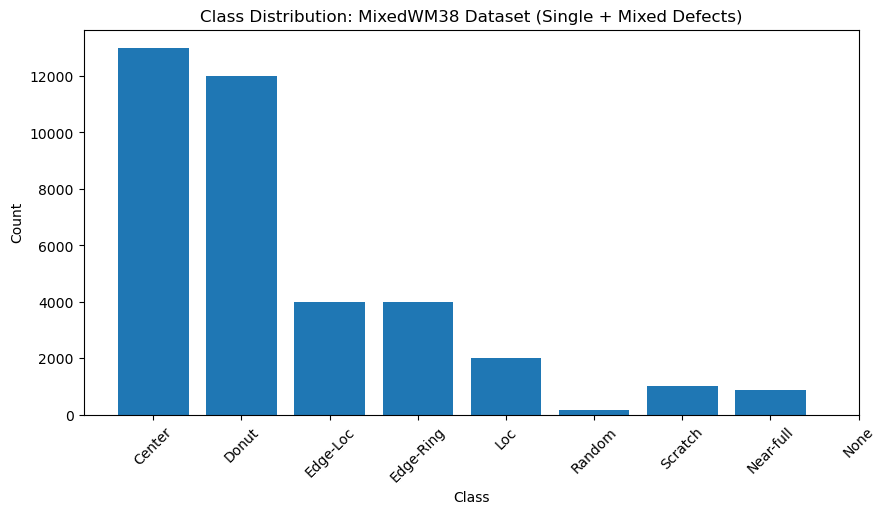

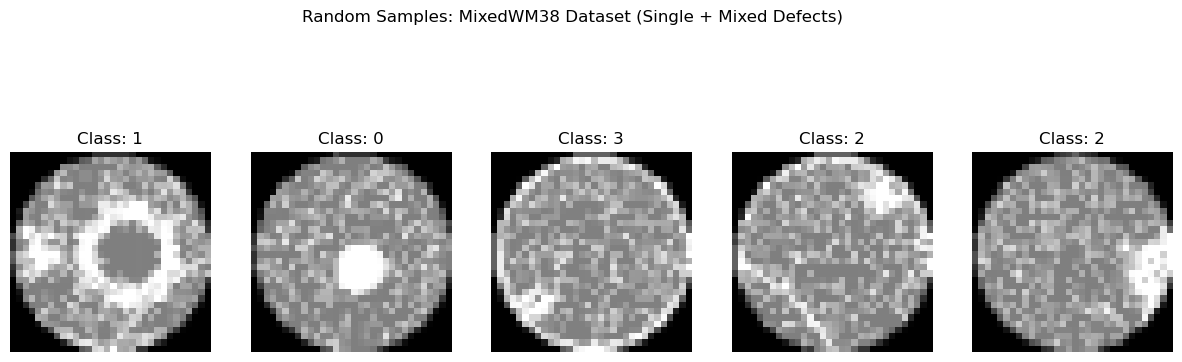

In [22]:
# Load Dataset2 (MixedWM38)
mixed_data, mixed_labels = preprocess_npz_dataset("data/MLWM38K.npz")

# Class Names for MixedWM38
mixed_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full','None']

# Visualize MixedWM38 Dataset
visualize_dataset(mixed_data, mixed_labels, title="MixedWM38 Dataset (Single + Mixed Defects)", classes=mixed_classes)


In [23]:
def visualize_mixed_defects(data, labels, title="Mixed Defect Wafer Maps Visualization", classes=None, cmap='gray'):
    """
    Visualizes the class distribution and random samples for mixed defect wafer maps.

    Parameters:
        data (np.ndarray): Wafer map images.
        labels (np.ndarray): Corresponding labels (one-hot encoded).
        title (str): Title for the visualization.
        classes (list, optional): Class names corresponding to labels.
        cmap (str): Colormap for grayscale images.
    """
    # Identify mixed defect wafer maps (labels with more than one "1")
    mixed_indices = [i for i, label in enumerate(labels) if np.sum(label) > 1]
    mixed_data = data[mixed_indices]
    mixed_labels = labels[mixed_indices]

    # Convert one-hot labels to scalar indices for mixed defects
    scalar_labels = [tuple(np.where(label == 1)[0]) for label in mixed_labels]

    # Plot class distribution for mixed defects
    label_counts = Counter(scalar_labels)
    plt.figure(figsize=(10, 5))
    plt.bar([str(k) for k in label_counts.keys()], label_counts.values())
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Mixed Defect Combination")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    # Display random samples of mixed defects
    fig, axes = plt.subplots(1, min(5, len(mixed_data)), figsize=(15, 5))
    indices = np.random.choice(len(mixed_data), size=min(5, len(mixed_data)), replace=False)
    for i, idx in enumerate(indices):
        axes[i].imshow(mixed_data[idx].squeeze(), cmap=cmap)
        axes[i].set_title(f"Defects: {scalar_labels[idx]}")
        axes[i].axis('off')
    plt.suptitle(f"Random Mixed Defect Samples: {title}")
    plt.show()


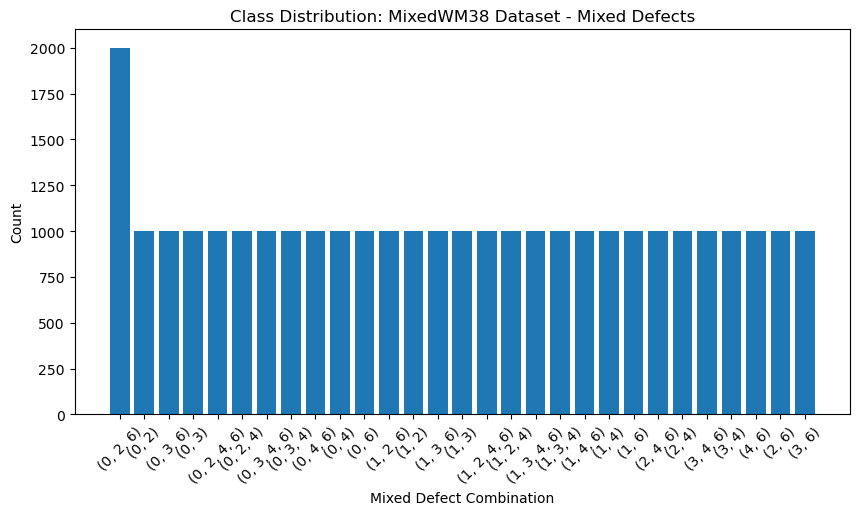

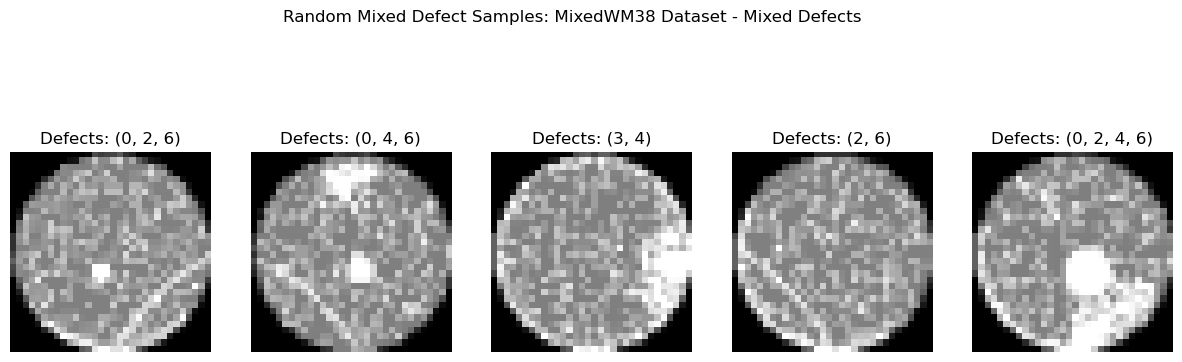

In [24]:
# Load Dataset2 (MixedWM38)
mixed_data, mixed_labels = preprocess_npz_dataset("data/MLWM38K.npz")

# Class Names for MixedWM38
mixed_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'None']

# Visualize Mixed Defect Wafer Maps
visualize_mixed_defects(mixed_data, mixed_labels, title="MixedWM38 Dataset - Mixed Defects", classes=mixed_classes)
